<a href="https://colab.research.google.com/github/m-hopwood/MonumentalTrees/blob/main/Tree_Figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
pip install -U kaleido

In [23]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size':15})
import seaborn as sns
import plotly.express as px
import plotly.colors as pc
import matplotlib.cm as cm
from matplotlib import gridspec
from scipy.stats import shapiro, pearsonr, spearmanr, pointbiserialr, kruskal
from google.colab import files

In [24]:
uploaded = files.upload()

In [ ]:
files.download("Height v Diameter.html")
files.download("Height v Diameter.png")
files.download("land_use.png")
files.download("correlation_plots.png")

FileNotFoundError: Cannot find file: Height v Diameter.html

In [ ]:
files.download('correlation_plots.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
T = pd.read_csv('Tree_Measurements_7.csv')

In [ ]:
T_P = T[T['Tree present?'] == 'Yes']
T_P = T_P[T_P['Tree accessible?'] == 'Yes']

score_map = {
    'Wilted or dry?': {'No': 1, 'Yes': 0},
    'Spots or holes?': {'No': 1, 'Yes': 0},
    'Crown / Canopy Density': {'100-80%': 1, '60-80%': 0.5, '<50%': 0},
    'Mistletoe': {'No': 1, 'Yes': 0},
    'Damaged, broken, or dead branches?': {'Yes': 0, 'No': 1},
    'Insect, birds, or other animals chewed or scratched the bark?': {'Yes': 0, 'No': 1},
    'Damage from humans?': {'Yes': 0, 'No': 1},
    'Percentage of trunk intact?': {'100%': 1, '80-90%': 0.8, '40-80%': 0.6, '20-40%': 0.4, '0-10%': 0},
    'Fungi visible?': {'Yes': 0, 'No': 1},
    'Codominant branches present?': {'0': 1, '1-2': 0.5, '>3': 0},
    'Roots at surface': {'Radiate like spokes': 1, 'Wrap around trunk': 0},
    'Competing?': {'Yes': 0, 'No': 1},
    'Access to sunlight?': {'Yes': 1, 'No': 0}
}

def calculate_health_index(row):
    total_score = 0
    for col, mapping in score_map.items():
        val = str(row[col]).strip()
        # Assign score if known category, else 0
        total_score += mapping.get(val, 0)
    return total_score

T_P['Health Index'] = T_P.apply(calculate_health_index, axis=1)

<ipython-input-6-2635560291>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_P['Health Index'] = T_P.apply(calculate_health_index, axis=1)


In [ ]:
native=T_P[T_P['Native'] == 'Yes']
non_native=T_P[T_P['Native'] == 'No']

In [ ]:
# Optional: Define custom color palette for 'Yes' and 'No'
native_colors = ['blue', 'red']  # green for 'Yes', red for 'No'
# Create a copy of the column with better labels
T_P['NativeLabel'] = T_P['Native'].map({'Yes': 'Native', 'No': 'Non-Native'})

fig1 = px.scatter(
    T_P,
    x='Basal Area (m^2)',
    y='Average Height (m)',
    color='NativeLabel',
    color_discrete_sequence=native_colors,
    labels={'NativeLabel': 'Native Species',
            'Average Height (m)': 'Height (m)'}
)

# Map trace name back to the original values in T_P
label_to_df = {
    'Native': T_P[T_P['NativeLabel'] == 'Native'],
    'Non-Native': T_P[T_P['NativeLabel'] == 'Non-Native']
}

# Update each trace with matching customdata
for trace in fig1.data:
    label = trace.name
    df_subset = label_to_df[label]

    df_subset = df_subset.copy()  # Make an explicit copy to avoid chained assignment
    df_subset.loc[:, 'Average Circumference (m)'] = df_subset['Average Circumference (m)'].replace([np.nan, None, ''], '')
    df_subset.loc[:, 'Basal Area (m^2)'] = df_subset['Basal Area (m^2)'].replace([np.nan, None, ''], '')


    trace.update(marker=dict(symbol='x', size=7))

    trace.customdata = df_subset[['Common Name', 'Scientific Name', 'Tree ID',
                                  'Average Circumference (m)', 'Average Height (m)',
                                  'NativeLabel', 'Health Index']].values

    trace.hovertemplate = (
        'Species: %{customdata[1]} (%{customdata[0]})<br>' +
        'Tree ID: %{customdata[2]}<br>' +
        'Circumference: %{customdata[3]:.2f} m<br>' +
        'Height: %{customdata[4]:.2f} m<br>' +
        '%{customdata[5]}<br>' +
        'Health index score: %{customdata[6]}<br>' +
        '<extra></extra>'
    )

fig1.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        range=[0, T_P['Basal Area (m^2)'].max() * 1.1],
        showgrid=False, showline=True, linecolor='lightgrey', mirror=True
    ),
    yaxis=dict(
        range=[0, T_P['Average Height (m)'].max() * 1.1],
        showgrid=False, showline=True, linecolor='lightgrey', mirror=True
    ),
    width=1000,
    height=700,
    margin=dict(l=60, r=40, t=60, b=60),
    font=dict(
        family="Times New Roman",
        size=20,  # Set the font size here
        color="black"
    )
)
fig1.update_xaxes(title_text=r"$\mathrm{Basal\ Area}\ (m^2)$")
fig1.update_yaxes(title_text=r"$\mathrm{Height}\ (m)$")

fig1.show()
fig1.write_image("Height v Diameter.png", width=1200, height=800, scale=3)
fig1.write_html('Height v Diameter.html', full_html=True, include_plotlyjs='inline', include_mathjax='cdn')

<ipython-input-8-3321355160>:28: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.395 '' 3.913333333 2.973333333 4.176666667 6.15 2.91 6.863333333
 4.963333333 3.613333333 3.15 3.443333333 5.626666667 4.656666667
 5.326666667 6.113333333 4.96 4.995 4.21 2.87 3.196666667 2.426666667 2.24
 2.01 3.28 4.645 3.41 5.076666667 3.745 4.013333333 2.816666667
 3.493333333 3.083333333 4.55 3.81 4.116666667 3.953333333 6.08
 2.923333333 3.953333333]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



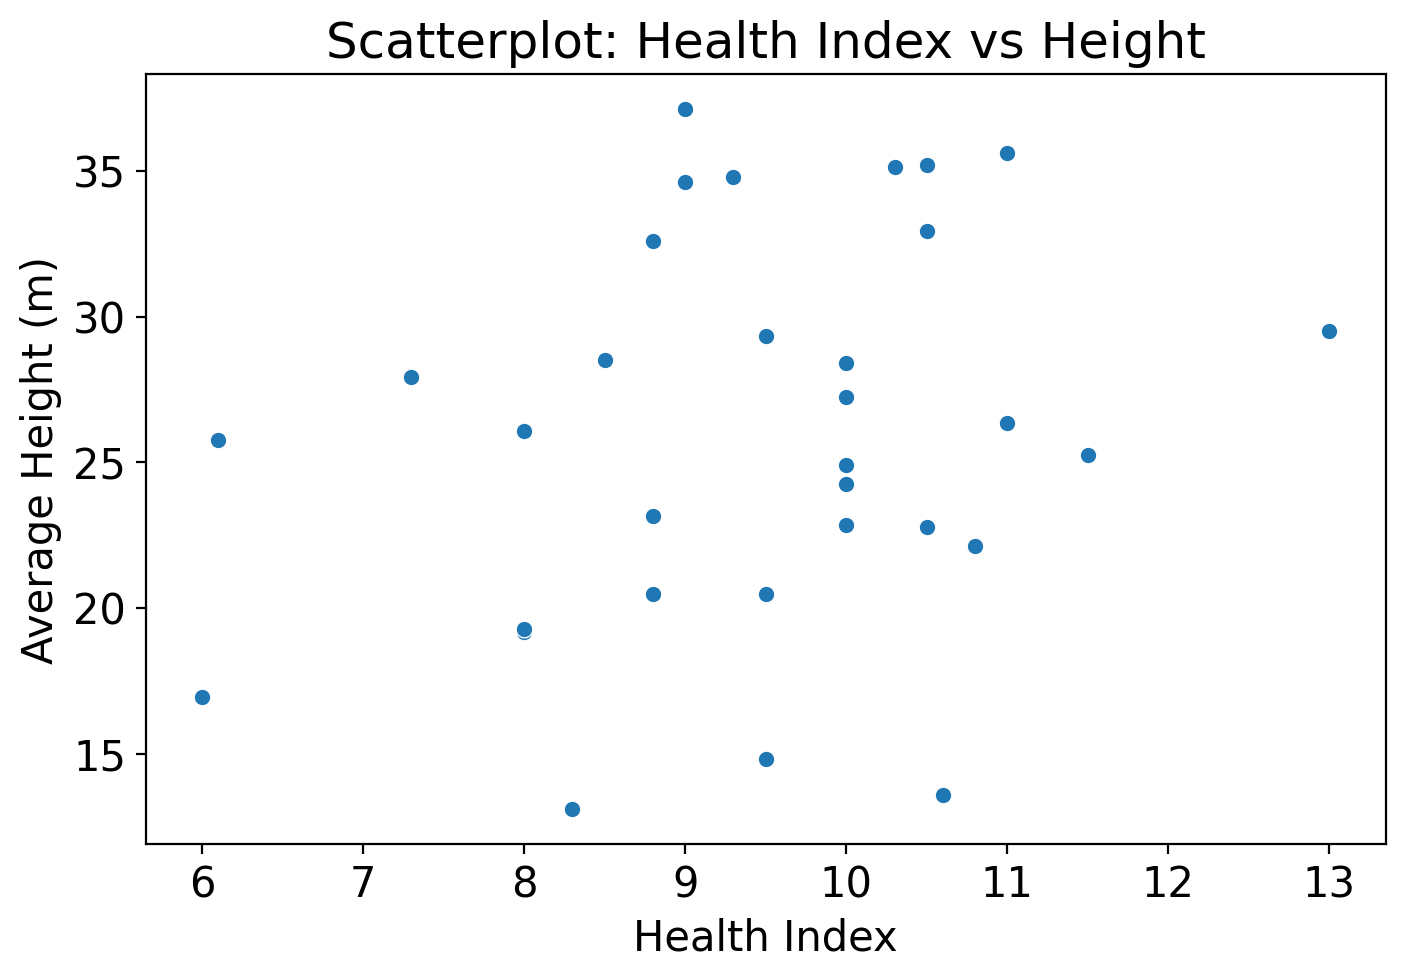

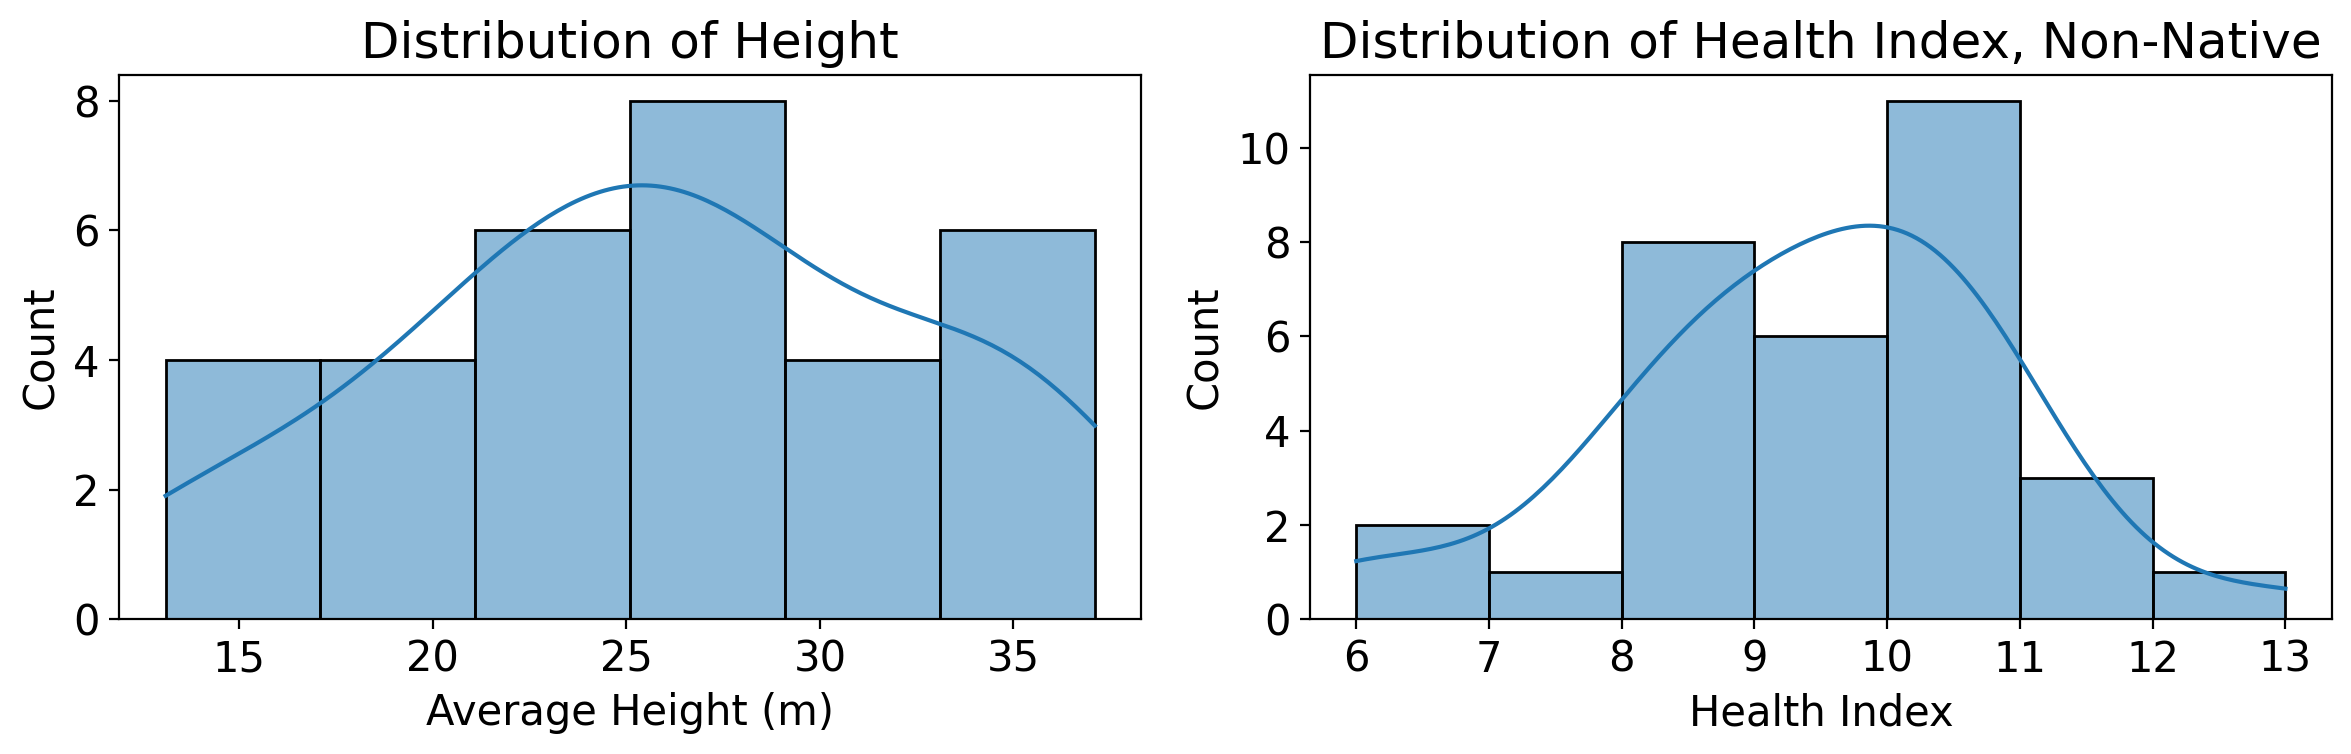

In [32]:
# Replace with your columns
x = non_native['Average Height (m)']
y = non_native['Health Index']

# Scatter plot to check relationship shape
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y, y=x)
plt.title('Scatterplot: Health Index vs Height')
plt.show()

# Histograms to check distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(x.dropna(), kde=True, ax=axs[0])
axs[0].set_title('Distribution of Height')

sns.histplot(y.dropna(), kde=True, ax=axs[1])
axs[1].set_title('Distribution of Health Index, Non-Native')

plt.tight_layout()

plt.show()

In [30]:
def correlation_report(df, col_x, col_y):
    # Drop rows with NaN in either column
    df_cleaned = df[[col_x, col_y]].dropna()
    x = df_cleaned[col_x]
    y = df_cleaned[col_y]

    # Normality tests
    stat_x, p_x = shapiro(x)
    stat_y, p_y = shapiro(y)

    print(f'\nCorrelation Test between {col_x} and {col_y}')

    print(f'Normality test results:')
    print(f'{col_x}: W={stat_x:.3f}, p={p_x:.3f}')
    print(f'{col_y}: W={stat_y:.3f}, p={p_y:.3f}')

    # Suggest correlation based on normality
    if p_x > 0.05 and p_y > 0.05:
        print("Both variables are normally distributed → Pearson correlation recommended.")
    else:
        print("At least one variable is not normal → Spearman correlation recommended.")

    # Calculate correlations
    pearson_corr, pearson_p = pearsonr(x, y)
    spearman_corr, spearman_p = spearmanr(x, y)

    print(f'Correlation results between {col_x} and {col_y}:')
    print(f'Pearson r = {pearson_corr:.3f}, p = {pearson_p:.3g}')
    print(f'Spearman rho = {spearman_corr:.3f}, p = {spearman_p:.3g}\n')

In [31]:
print(f"\nCorrelation Reports for Full Dataset")
correlation_report(T_P, 'Basal Area (m^2)', 'Health Index')
correlation_report(T_P, 'Average Height (m)', 'Health Index')
correlation_report(T_P, 'Basal Area (m^2)', 'Average Height (m)')

print(f"\nCorrelation Reports for Native trees only")
correlation_report(native, 'Basal Area (m^2)', 'Health Index')
correlation_report(native, 'Average Height (m)', 'Health Index')
correlation_report(native, 'Basal Area (m^2)', 'Average Height (m)')

print(f"\nCorrelation Reports for Non-native trees only")
correlation_report(non_native, 'Basal Area (m^2)', 'Health Index')
correlation_report(non_native, 'Average Height (m)', 'Health Index')
correlation_report(non_native, 'Basal Area (m^2)', 'Average Height (m)')


Correlation Reports for Full Dataset

Correlation Test between Basal Area (m^2) and Health Index
Normality test results:
Basal Area (m^2): W=0.917, p=0.000
Health Index: W=0.823, p=0.000
At least one variable is not normal → Spearman correlation recommended.
Correlation results between Basal Area (m^2) and Health Index:
Pearson r = 0.095, p = 0.428
Spearman rho = 0.120, p = 0.315


Correlation Test between Average Height (m) and Health Index
Normality test results:
Average Height (m): W=0.982, p=0.387
Health Index: W=0.852, p=0.000
At least one variable is not normal → Spearman correlation recommended.
Correlation results between Average Height (m) and Health Index:
Pearson r = 0.305, p = 0.0097
Spearman rho = 0.341, p = 0.00363


Correlation Test between Basal Area (m^2) and Average Height (m)
Normality test results:
Basal Area (m^2): W=0.919, p=0.000
Average Height (m): W=0.982, p=0.387
At least one variable is not normal → Spearman correlation recommended.
Correlation results betwe

In [ ]:
# Drop rows with missing values
subset = T_P[['Subcategory Land Use', 'Health Index']].dropna()
subset_nat = native[['Subcategory Land Use', 'Health Index']].dropna()
subset_non = non_native[['Subcategory Land Use', 'Health Index']].dropna()

# Group Health Index by land use subcategories
grouped_data = [group['Health Index'].values for name, group in subset.groupby('Subcategory Land Use')]
grouped_data_nat = [group['Health Index'].values for name, group in subset_nat.groupby('Subcategory Land Use')]
grouped_data_non = [group['Health Index'].values for name, group in subset_non.groupby('Subcategory Land Use')]

# Run Kruskal-Wallis test
stat, p = kruskal(*grouped_data)
stat_nat, p_nat = kruskal(*grouped_data_nat)
stat_non, p_non = kruskal(*grouped_data_non)

# Print results
print(f"\nKruskal-Wallis H = {stat:.3f}, p = {p:.3g}")
print(f"\nKruskal-Wallis H = {stat_nat:.3f}, p = {p_nat:.3g}")
print(f"\nKruskal-Wallis H = {stat_non:.3f}, p = {p_non:.3g}")


Kruskal-Wallis H = 7.767, p = 0.354

Kruskal-Wallis H = 7.909, p = 0.341

Kruskal-Wallis H = 0.478, p = 0.924


In [ ]:
subset2 = T_P[['Native', 'Health Index']].dropna()
grouped_data2 = [group['Health Index'].values for name, group in subset2.groupby('Native')]
stat2, p2 = kruskal(*grouped_data2)

print(f"\nKruskal-Wallis H = {stat2:.3f}, p = {p2:.3g}")

subset3 = T_P[['Scientific Name', 'Health Index']].dropna()
grouped_data3 = [group['Health Index'].values for name, group in subset3.groupby('Scientific Name')]
stat3, p3 = kruskal(*grouped_data3)

print(f"\nKruskal-Wallis H = {stat3:.3f}, p = {p3:.3g}")


Kruskal-Wallis H = 4.079, p = 0.0434

Kruskal-Wallis H = 37.635, p = 0.131


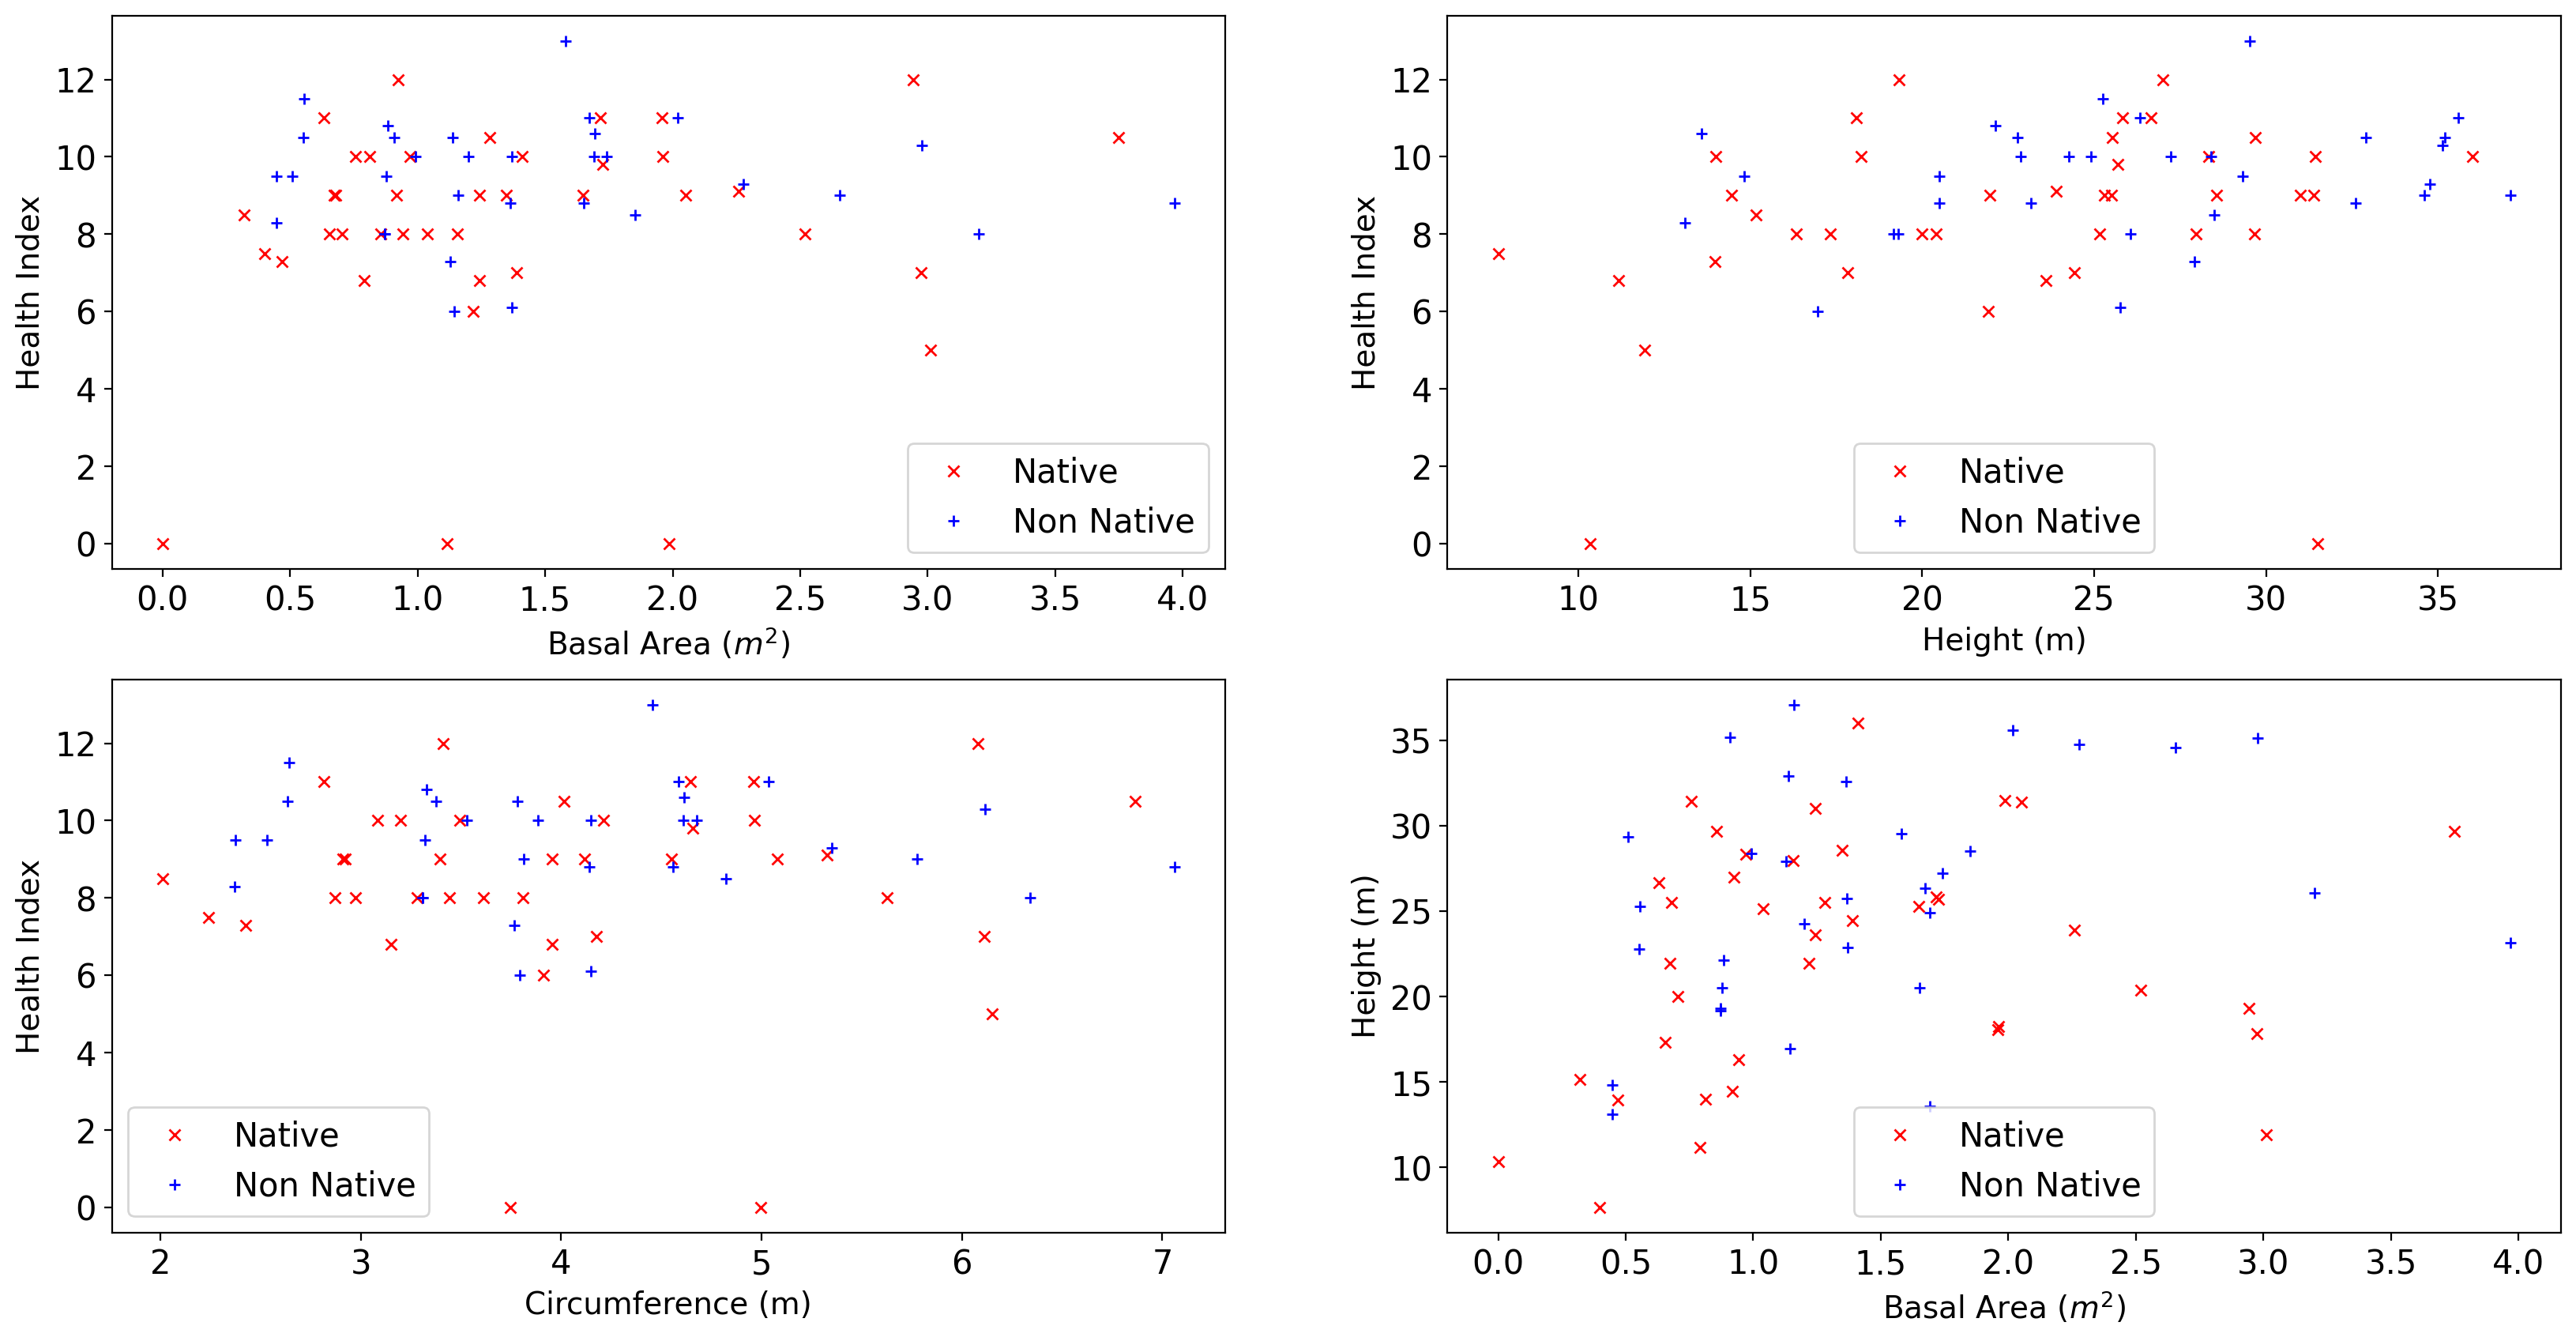

In [ ]:
fig2 = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
#gs = gridspec.GridSpec(1, 3)

ax2 = fig2.add_subplot(gs[0, 0])
ax2.plot(native['Basal Area (m^2)'], native['Health Index'],
         color='red', marker='x', markersize=5, linestyle='None', label='Native')
ax2.plot(non_native['Basal Area (m^2)'], non_native['Health Index'],
         color='blue', marker='+', markersize=5, linestyle='None', label='Non Native')
ax2.set_xlabel(r"$\mathrm{Basal\ Area}\ (m^2)$", fontsize=14)
ax2.set_ylabel('Health Index', fontsize=14)
ax2.legend()

ax3 = fig2.add_subplot(gs[0, 1])
ax3.plot(native['Average Height (m)'], native['Health Index'],
         color='red', marker='x', markersize=5, linestyle='None', label='Native')
ax3.plot(non_native['Average Height (m)'], non_native['Health Index'],
         color='blue', marker='+', markersize=5, linestyle='None', label='Non Native')
ax3.set_xlabel('Height (m)', fontsize=14)
ax3.set_ylabel('Health Index', fontsize=14)
ax3.legend()

ax4 = fig2.add_subplot(gs[1, 0])
ax4.plot(native['Average Circumference (m)'], native['Health Index'],
         color='red', marker='x', markersize=5, linestyle='None', label='Native')
ax4.plot(non_native['Average Circumference (m)'], non_native['Health Index'],
         color='blue', marker='+', markersize=5, linestyle='None', label='Non Native')
ax4.set_xlabel('Circumference (m)', fontsize=14)
ax4.set_ylabel('Health Index', fontsize=14)
ax4.legend()

ax5 = fig2.add_subplot(gs[1, 1])
ax5.plot(native['Basal Area (m^2)'], native['Average Height (m)'],
         color='red', marker='x', markersize=5, linestyle='None', label='Native')
ax5.plot(non_native['Basal Area (m^2)'], non_native['Average Height (m)'],
         color='blue', marker='+', markersize=5, linestyle='None', label='Non Native')
ax5.set_xlabel(r"$\mathrm{Basal\ Area}\ (m^2)$", fontsize=14)
ax5.set_ylabel('Height (m)', fontsize=14)
ax5.legend()

plt.show()
fig2.savefig('correlation_plots.png')

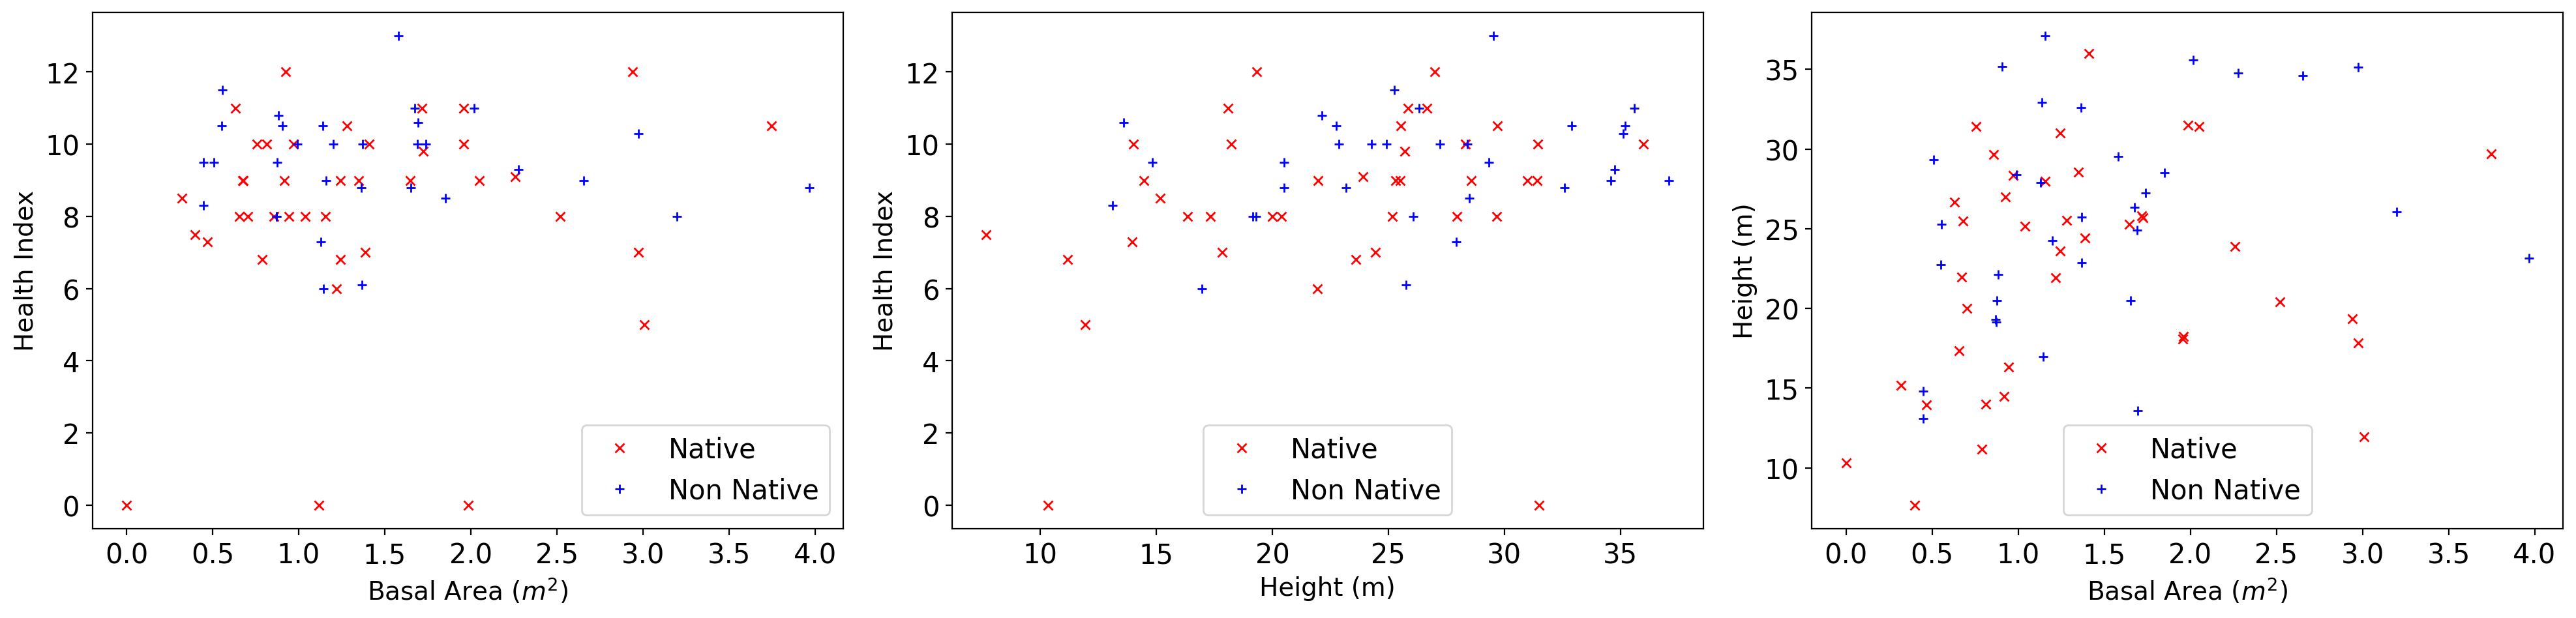

In [ ]:
fig6 = plt.figure(figsize=(20,5))
#gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
gs = gridspec.GridSpec(1, 3)

ax6 = fig6.add_subplot(gs[0, 0])
ax6.plot(native['Basal Area (m^2)'], native['Health Index'],
         color='red', marker='x', markersize=5, linestyle='None', label='Native')
ax6.plot(non_native['Basal Area (m^2)'], non_native['Health Index'],
         color='blue', marker='+', markersize=5, linestyle='None', label='Non Native')
ax6.set_xlabel(r"$\mathrm{Basal\ Area}\ (m^2)$", fontsize=14)
ax6.set_ylabel('Health Index', fontsize=14)
ax6.legend()

ax7 = fig6.add_subplot(gs[0, 1])
ax7.plot(native['Average Height (m)'], native['Health Index'],
         color='red', marker='x', markersize=5, linestyle='None', label='Native')
ax7.plot(non_native['Average Height (m)'], non_native['Health Index'],
         color='blue', marker='+', markersize=5, linestyle='None', label='Non Native')
ax7.set_xlabel('Height (m)', fontsize=14)
ax7.set_ylabel('Health Index', fontsize=14)
ax7.legend()

ax8 = fig6.add_subplot(gs[0, 2])
ax8.plot(native['Basal Area (m^2)'], native['Average Height (m)'],
         color='red', marker='x', markersize=5, linestyle='None', label='Native')
ax8.plot(non_native['Basal Area (m^2)'], non_native['Average Height (m)'],
         color='blue', marker='+', markersize=5, linestyle='None', label='Non Native')
ax8.set_xlabel(r"$\mathrm{Basal\ Area}\ (m^2)$", fontsize=14)
ax8.set_ylabel('Height (m)', fontsize=14)
ax8.legend()

plt.tight_layout()
fig6.savefig('correlation_plots.png')
plt.show()

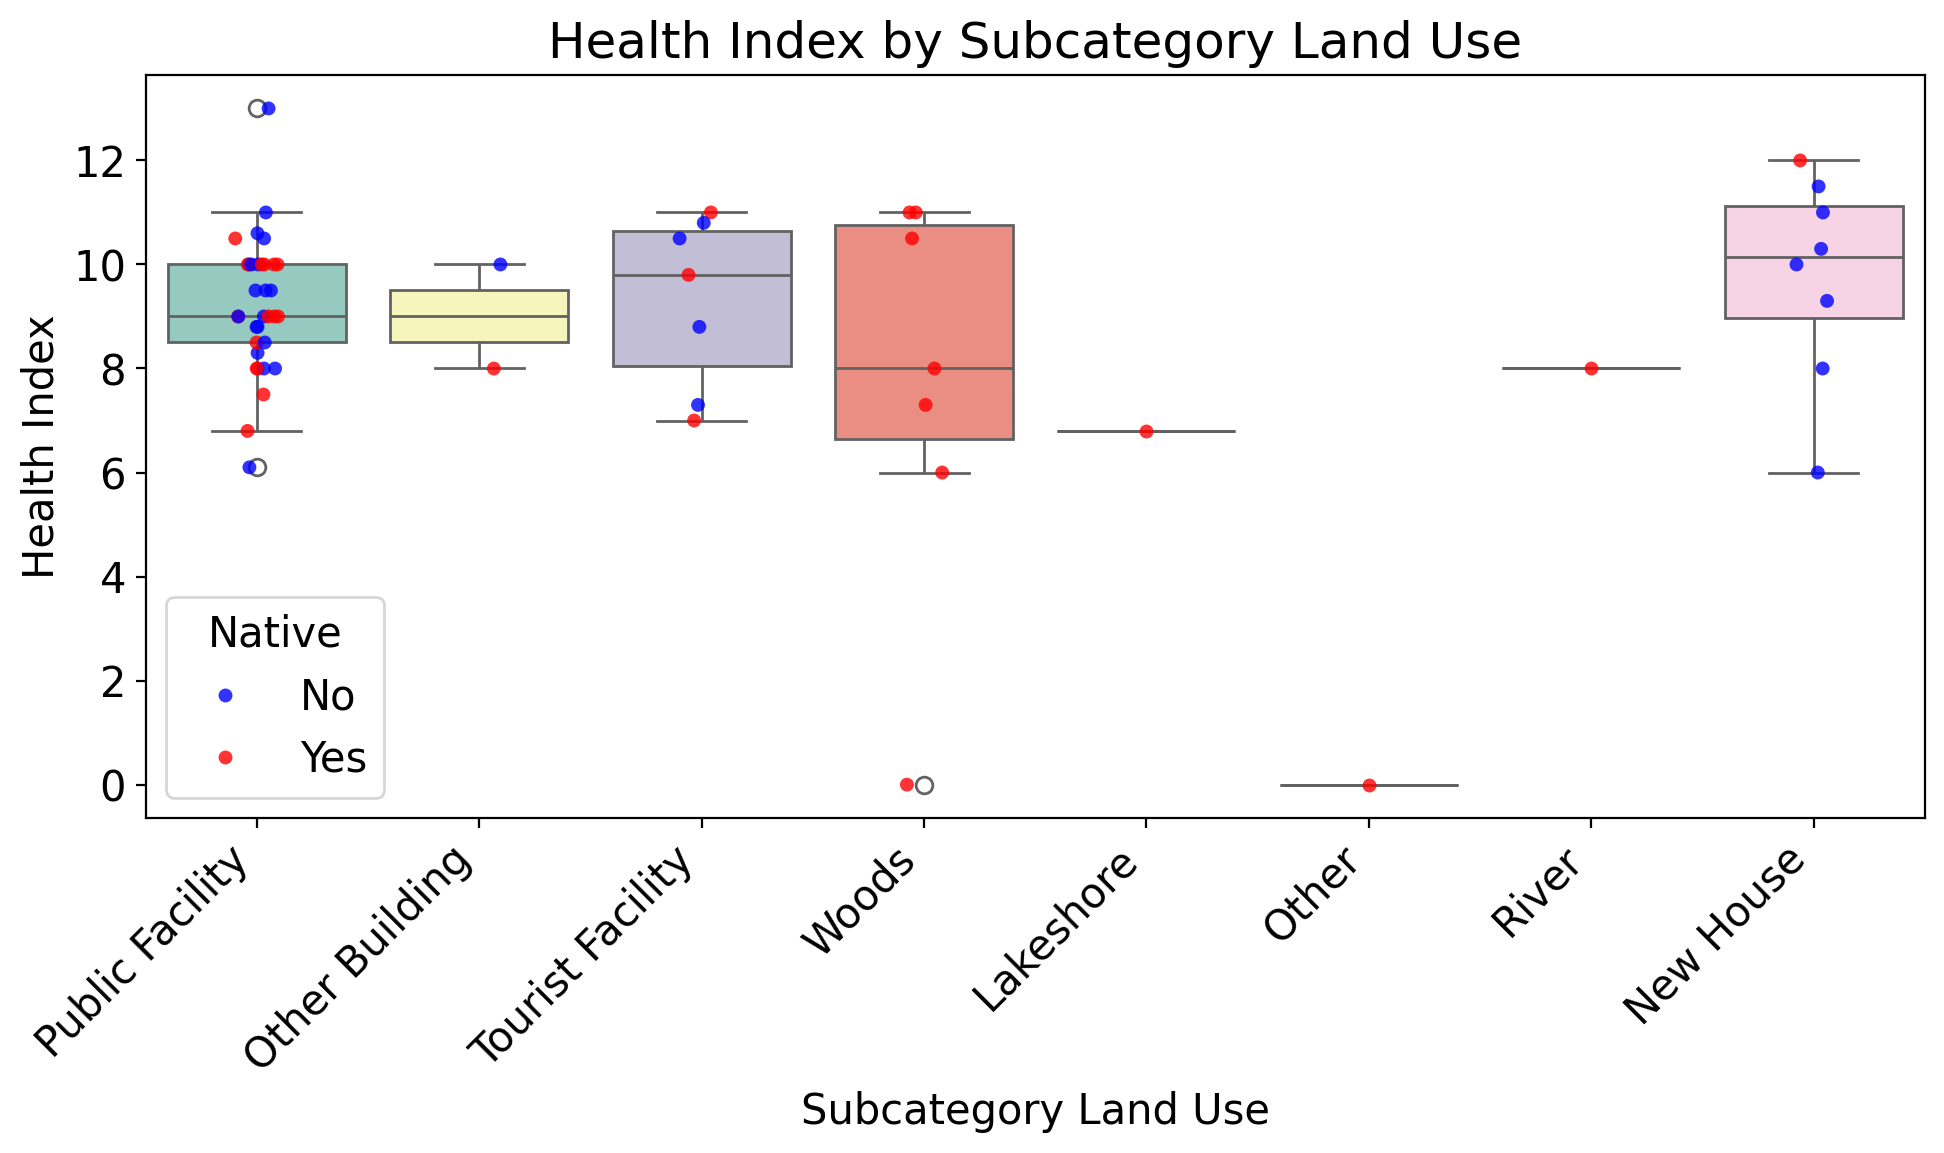

In [ ]:
# Define custom color palette for 'Native' vs 'Non-Native'
custom_palette = {'Yes': 'red', 'No': 'blue'}

# Create the plot
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(x='Subcategory Land Use', y='Health Index', data=T_P, palette='Set3', hue='Subcategory Land Use', legend=False)

# Stripplot, color by 'Native' with custom palette
sns.stripplot(x='Subcategory Land Use', y='Health Index', data=T_P,
              hue='Native', jitter=True, alpha=0.8, size=5, palette=custom_palette)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add title
plt.title('Health Index by Subcategory Land Use')

# Display the plot
plt.tight_layout()
plt.savefig('land_use.png')
plt.show()